# Problem Set 7

In [1]:
import os
os.chdir(r"/Users/yahsk/Desktop/Q1/investments/All HW and solutions")
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
from functools import reduce
import quadprog as QD
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Prepare data
#load data 
#stock data
df_list = []
for i in range(0,5):
    df = pd.read_excel('lecture6p_2022.xlsx', sheet_name = i)
    #new_df = function(df)
    df_list.append(df)

#load Fama French data
ff = pd.read_excel('lecture6p_2022.xlsx', sheet_name = "F-F_Research_Data_Factors_daily")

begindate = "1989-12-29"
enddate = "2022-08-31"
def cleandt(d):
    d.columns = d.columns.str.lower()
    filt = (d['date'] >= begindate) & (d['date'] <= enddate)
    d = d.loc[filt]
    d = d[["date","adjclose"]]
    return d

df_list_new = [cleandt(d) for d in df_list]

df_list_new[0] = df_list_new[0].rename(columns = { "adjclose":"MSFT"})
df_list_new[1] = df_list_new[1].rename(columns = { "adjclose":"INTC"})
df_list_new[2] = df_list_new[2].rename(columns = { "adjclose":"LUV"})
df_list_new[3] = df_list_new[3].rename(columns = { "adjclose":"MCD"})
df_list_new[4] = df_list_new[4].rename(columns = { "adjclose":"JNJ"})

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'], how='outer'), df_list_new)

# clean fama french data 
ff.columns = ff.columns.str.lower()
ff = ff[["date", "mktrf", "rf"]]
ff["rf"] = ff["rf"]/100
ff["mktrf"] = ff["mktrf"]/100
ff['rfleveladj'] = (ff['rf']+1).cumprod()
ff["mktrfleveladj"] = (ff['mktrf']+1).cumprod()
filt = (ff['date'] >= begindate) & (ff['date'] <= enddate)
ff = ff.loc[filt]

d = pd.merge(ff, df_merged, how="inner", on=["date"])

d['Date'] = d['date']
d = d.set_index('date')
d = d.resample('W-Fri').last()


d['rf'] = (d['rfleveladj']/d['rfleveladj'].shift() -1).shift()  #recreate the new rf
d['mktrf'] = (d['mktrfleveladj']/d['mktrfleveladj'].shift() -1)#recreate the excess market return
d['MSFT'] = (d['MSFT']/d['MSFT'].shift() -1)
d['INTC'] = (d['INTC']/d['INTC'].shift() -1)
d['LUV'] = (d['LUV']/d['LUV'].shift() -1)
d['MCD'] = (d['MCD']/d['MCD'].shift() -1)
d['JNJ'] = (d['JNJ']/d['JNJ'].shift() -1)

d= d.dropna()

## Question 1

**Construct weekly simple total returns from the price data (use Adj Close to include dividends).  Compute and report the weekly and annualized mean and standard deviation for each stock. Compute the correlation matrix.**

In [4]:
# Question 1 
dftable = d.iloc[:,4:9] #select all stocks 
def annret(x):
    result = (1+ x.mean())**52-1
    return result

def sd1y(x):
    result = x.std()*52**0.5
    return result

#standard deviation
res = dftable.agg([np.mean,np.std,annret, sd1y])
res*100

,MSFT,INTC,LUV,MCD,JNJ
mean,0.464026,0.347192,0.329452,0.284189,0.263041
std,4.056611,4.882379,4.767498,3.089438,2.812064
annret,27.218438,19.748964,18.653031,15.901304,14.637150
sd1y,29.252640,35.207332,34.378917,22.278254,20.278084


In [5]:
# creation of correlation matrix
corrM = dftable .corr()
corrM*100

,MSFT,INTC,LUV,MCD,JNJ
MSFT,100.000000,49.764945,29.642731,29.114271,28.836369
INTC,49.764945,100.000000,29.276234,25.645173,20.896255
LUV,29.642731,29.276234,100.000000,30.842842,24.905153
MCD,29.114271,25.645173,30.842842,100.000000,31.890180
JNJ,28.836369,20.896255,24.905153,31.890180,100.000000


## Question 2

**Construct the mean-variance frontier for the Intel-Microsoft combination. Indicate the minimum-variance portfolio and the efficient frontier (the efficient frontier is a set of expected returns - risks that you would want to consider investing in).**

Start by creating a some generic functions for computing the minimum variance frontier.

In [6]:
#Start by creating a some generic functions for computing the minimum variance frontier.
def setupminvol(z,S):
    n = len(z)
    some1s = np.repeat(1,n).astype("double")
    some0s = np.repeat(0,n).astype("double")
    A = np.c_[some1s,z].astype("double")
    Si = np.linalg.inv(S)
    return {'S':S, 'Si':Si, 'z':z, 'n':n, 'some1s':some1s, 'some0s':some0s, 'some1s':some1s, 'A':A}

def minvol(targ, p):
    result =  QD.solve_qp(2*p['S'],p['some0s'], p['A'], np.array([1,targ]),meq=2)
    return result[1] #value 


def minvolw(targ, p):
    result = QD.solve_qp(2*p['S'],p['some0s'], p['A'], np.array([1,targ]),meq=2)
    return result[0] #solution - 2 values 


targstocks2 = dftable[["MSFT", "INTC"]]
S2 = targstocks2.cov().to_numpy() #variance covariance matrix for MSFT and INTC
z2 = targstocks2.agg([np.mean]).to_numpy().T

p2 = setupminvol(z2, S2)
delta = 10**(-7)
targrets = np.arange(0.002,0.0070001,delta)[0:50000]

def targfunc(targ):
    return minvol(targ,p2)

targfunc_vec = np.vectorize(targfunc)
vols2 = targfunc_vec(targrets)
vols2 = vols2**0.5

#identify the global min var portfolio
volmin2 = min(vols2) #find the global min variance portfolio
rmin2 = targrets[vols2 == volmin2]
pos2 = np.array(["2" if x <= rmin2 else "1" for x in targrets])
data = np.c_[vols2,targrets,pos2]
df2 = pd.DataFrame(data = data, columns = ['x', 'y','pos'])
df2["2stocks"] = "2stocks"

df2['x'] = df2['x'].astype('float')
df2['y'] = df2['y'].astype('float')
df2['pos'] = df2['pos'].astype('int')
#this will make our graph look cleaner
x = np.append(np.sqrt(np.diag(p2['S'])),volmin2)
y = np.append(p2['z'],rmin2)
pt = np.array(["MSFT","INTC","globalmin"])
data = np.c_[x,y,pt]
specialpoints2 = pd.DataFrame(data, columns = ['x', 'y','pt'])
specialpoints2['x'] = specialpoints2['x'].astype("float").round(5)
specialpoints2['y']  = specialpoints2['y'].astype("float").round(5)

Next, run the functions for the two focal stocks and plot the results:

(0.002, 0.006)

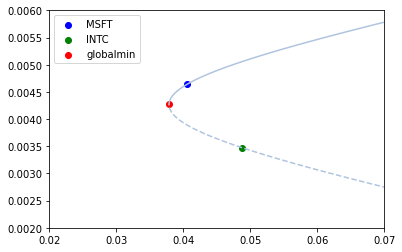

In [7]:
##################################
# Plot Question 2
pos1 = df2.loc[(df2.pos == 1)]
pos2 = df2.loc[(df2.pos == 2)]

points = specialpoints2
cdict = {0: 'blue', 1: 'green', 2: 'red'}
for g, row in points.iterrows():
    plt.scatter(row.x, row.y,c = cdict[g])

plt.legend(points['pt'])
plt.plot(pos1.x,pos1.y, color = 'lightsteelblue')
plt.plot(pos2.x,pos2.y, linestyle = 'dashed', color = 'lightsteelblue')
plt.xlim(0.02, 0.07)
plt.ylim(0.002, 0.006)

## Question 3

**Add remaining stocks to the mix. Compute the mean-variance frontier and plot it on the same chart with the one from the previous question. Indicate the minimum-variance portfolio and the efficient frontier. How do they compare to those of the previous question?**

We already did most of the workin in the previous question. Adding more assets is just a matter of calling the functions for more stocks. The additional stocks move the minimum frontier upward and inward. Of course, the marginal effect declines as the number of assets increases.

In [8]:
targstocks5 = dftable
S5 = targstocks5.cov().to_numpy() #variance covariance matrix for MSFT and INTC
z5 = targstocks5.agg([np.mean]).to_numpy().T

p5 = setupminvol(z5, S5)
#delta = 10**(-7)
#targrets = np.arange(0.002,0.0070001,delta)[0:50000]

def targfunc(targ):
    return minvol(targ,p5)

targfunc_vec = np.vectorize(targfunc)
vols5 = targfunc_vec(targrets)
vols5 = vols5**0.5

#identify the global min var portfolio
volmin5 = min(vols5) #find the global min variance portfolio
rmin5 = targrets[vols5 == volmin5]
pos5 = np.array(["2" if x <= rmin2 else "1" for x in targrets])
data = np.c_[vols5,targrets,pos5]
df5 = pd.DataFrame(data = data, columns = ['x', 'y','pos'])
df5['x'] = df5['x'].astype('float')
df5['y'] = df5['y'].astype('float')
df5['pos'] = df5['pos'].astype('int')
df5["frontier"] = "5 stocks"
df2.rename(columns = {'2stocks':'frontier'}, inplace = True)
df25 = df5.append(df2, ignore_index = True )

#df2["2stocks"] = "2stocks"

#this will make our graph look cleaner
x = np.append(np.sqrt(np.diag(p5['S'])),[volmin2,volmin5])
y = np.append(p5['z'],[rmin2, rmin5])
pt = np.array(["MSFT","INTC","LUV","MCD","JNJ","2-stocks min","5-stocks min"])
data = np.c_[x,y,pt]
specialpoints2 = pd.DataFrame(data, columns = ['x', 'y','pt'])
specialpoints2['x'] = specialpoints2['x'].astype("float").round(5)
specialpoints2['y']  = specialpoints2['y'].astype("float").round(5)

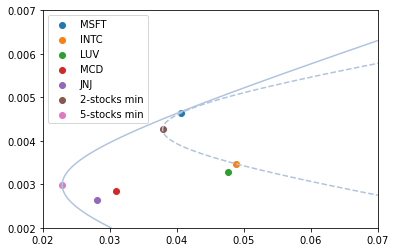

In [9]:
# Plot q3
pos1 = df25.loc[(df25.frontier == "2stocks")]
pos2 = df25.loc[(df25.frontier == "5 stocks")]

points = specialpoints2
#cdict = {0: 'blue', 1: 'green', 2: 'red'}
for g, row in points.iterrows():
    plt.scatter(row.x, row.y) #c = cdict[g]

plt.legend(points['pt'],loc = "upper left")
plt.xlim(0.02, 0.07)
plt.ylim(0.002, 0.007)


plt.plot(pos1.x,pos1.y, linestyle = 'dashed', color = 'lightsteelblue')
plt.plot(pos2.x,pos2.y, linestyle = 'solid', color = 'lightsteelblue')

# Question 4

**Add the riskless asset and construct the tangent portfolio for the Intel-Microsoft case. Next, construct the tangent portfolio for the full set of stocks. Compare the Sharpe ratios of the two tangent portfolios.**

In [10]:
rfr = d['rf'].mean()
sharpe2 = (targrets-rfr)/vols2
sharpe5 = (targrets-rfr)/vols5
  
tang2 = np.where(sharpe2==max(sharpe2))
tang5 = np.where(sharpe5==max(sharpe5))

x= np.append(vols2[tang2[0]],vols5[tang5[0]])
y= np.append(targrets[tang2[0]],targrets[tang5[0]])
intercepts = np.append(rfr,rfr)
slopes = np.append(sharpe2[tang2[0]], sharpe5[tang5[0]])
portfolio = np.append("Sharpe ratio ="+str(sharpe2[tang2[0]]), "Sharpe ratio ="+str(sharpe5[tang5[0]]))

data = np.c_[x,y,intercepts,slopes,portfolio]
specialpoints4 = pd.DataFrame(data, columns = ['x', 'y','intercepts','slopes','portfolio'])
specialpoints4['x'] = specialpoints4['x'].astype("float").round(5)
specialpoints4['y']  = specialpoints4['y'].astype("float").round(5)
specialpoints4['intercepts']  = specialpoints4['intercepts'].astype("float").round(5)
specialpoints4['slopes']  = specialpoints4['slopes'].astype("float").round(5)

### Run this whole chunk to plot 
pos1 = df25.loc[(df25.frontier == "2stocks")]
pos2 = df25.loc[(df25.frontier == "5 stocks")]

#add 2 points of sharpe to special points2 
twopt= specialpoints4[['x','y','portfolio']]
twopt.rename(columns={'portfolio':'pt'}, inplace=True)
specialpoints2 = specialpoints2.append(twopt)

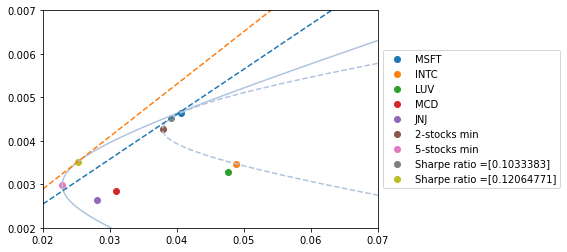

In [11]:
#Plot Q4
points = specialpoints2
#cdict = {0: 'blue', 1: 'green', 2: 'red'}
for g, row in points.iterrows():
    plt.scatter(row.x, row.y) #c = cdict[g]

plt.legend(points['pt'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0.02, 0.07)
plt.ylim(0.002, 0.007)

plt.plot(pos1.x,pos1.y, linestyle = 'dashed', color = 'lightsteelblue')
plt.plot(pos2.x,pos2.y, linestyle = 'solid', color = 'lightsteelblue')

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
abline(specialpoints4['slopes'].iloc[0], specialpoints4['intercepts'].iloc[0])
abline(specialpoints4['slopes'].iloc[1], specialpoints4['intercepts'].iloc[1])

# Question 5

**Assume your risk aversion is A = 3.5: What is your optimal mix of assets?**

$$
\begin{aligned}
  w_{risky} &= \frac{E(R_{tang}) - R_{f}}{A \cdot V(R_{tang})}
\end{aligned}
$$

Compute the portfolio weight as the product of the tangency weights and the weight on the tangency portfolio. The risk-free portfolio weight is the residual. The negative weight implies borrowing, while a positive rate would have implied a risk-free bond investment.

In [13]:
# Question 5 ####
#get the tangency weights
A = 3.5
w5 = minvolw(targrets[tang5[0]][0],p5)
#compute the weight on the risky and risk-free portfolio
wrisky = (targrets[tang5[0]][0] - rfr)/(A*vols5[tang5[0]][0]**2)
wrfr = 1 - wrisky
res3 = pd.DataFrame(np.zeros((6,2)), columns =["wtangent", "w (A = 3.5)"])
res3.index = ["msft", "intc", "luv", "mcd","jnj","RFR"]
res3.wtangent = np.append(w5,0)
res3["w (A = 3.5)"] = np.append(wrisky*w5,wrfr)
res3['wtangent'] = res3['wtangent'].astype("float")
round(res3*100,2)

,wtangent,w (A = 3.5)
msft,38.66,52.98
intc,0.79,1.08
luv,6.62,9.07
mcd,25.06,34.34
jnj,28.87,39.55
RFR,0.00,-37.02


The weight on the risky portfolio is 137.0, implying a weight of -37.0 on the risk-free asset.

In [18]:
d

,mktrf,rf,rfleveladj,mktrfleveladj,MSFT,INTC,LUV,MCD,JNJ,Date
date,,,,,,,,,,
1990-01-12,-0.035421,0.001040,1.002643,0.970099,-0.039052,-0.007041,-0.115789,-0.033835,-0.046122,1990-01-12
1990-01-19,-0.004412,0.001301,1.003947,0.965819,0.092889,0.074467,0.029762,-0.007782,0.008791,1990-01-19
1990-01-26,-0.041940,0.001301,1.005253,0.925312,-0.035857,0.023103,-0.052024,-0.019608,-0.078431,1990-01-26
1990-02-02,0.012263,0.001301,1.006641,0.936660,0.033059,0.019355,0.079269,0.064000,0.033097,1990-02-02
1990-02-09,0.010574,0.001381,1.008152,0.946564,0.008000,0.018987,-0.045197,-0.007519,0.027460,1990-02-09
...,...,...,...,...,...,...,...,...,...,...
2022-08-05,0.008685,0.000200,2.247093,10.598570,0.007730,-0.015498,0.018101,-0.015719,-0.019539,2022-08-05
2022-08-12,0.033912,0.000400,2.247992,10.957984,0.031812,0.020345,0.016748,0.011380,-0.033955,2022-08-12
2022-08-19,-0.015941,0.000400,2.248891,10.783299,-0.017651,-0.020216,-0.040040,0.016630,0.024259,2022-08-19


In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.sandwich_covariance import cov_hc3

def regstock(stock, data, mkt='mktrf'):
    y = data[stock]
    X = data[mkt]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC3')

    # Get beta, alpha and their standard errors
    beta = results.params[mkt]
    alpha = results.params['const']
    betase = results.bse[mkt]
    alphase = results.bse['const']

    # Get residuals standard error (equivalent to residse in R)
    residse = results.resid.std()

    # Calculate average return (equivalent to actr in R)
    actr = y.mean()

    # Calculate CAPM excess return (equivalent to capmr in R)
    capmr = actr - alpha

    return beta, alpha, betase, alphase, residse, actr, capmr


# stocknames are names of stocks you want to analyze.
# d is the dataframe which should include returns for each stock, market return and risk-free rate.
stocknames = ["MSFT", "INTC", "LUV", "MCD","JNJ"]
estocknames = ["e" + name for name in stocknames]
d[estocknames] = d[stocknames].subtract(d['rf'], axis=0)

reg_results = {name: regstock(name, d) for name in estocknames}

# Print results
beta_df = pd.DataFrame.from_dict({name: res[0] for name, res in reg_results.items()}, orient='index', columns=['beta'])
beta_err_df = pd.DataFrame.from_dict({name: res[2] for name, res in reg_results.items()}, orient='index', columns=['error (Mod-White)'])
alpha_df = pd.DataFrame.from_dict({name: res[1]*10000 for name, res in reg_results.items()}, orient='index', columns=['alpha (bp)'])
alpha_err_df = pd.DataFrame.from_dict({name: res[3]*10000 for name, res in reg_results.items()}, orient='index', columns=['alpha se (bp)'])
resid_err_df = pd.DataFrame.from_dict({name: res[4]*10000 for name, res in reg_results.items()}, orient='index', columns=['idiosync. risk (bp)'])

# Add new results
actr_df = pd.DataFrame.from_dict({name: res[5] for name, res in reg_results.items()}, orient='index', columns=['actr'])
capmr_df = pd.DataFrame.from_dict({name: res[6] for name, res in reg_results.items()}, orient='index', columns=['capmr'])

print(beta_df.join(beta_err_df))
print(alpha_df.join(alpha_err_df).join(resid_err_df))
print(actr_df.join(capmr_df))



           beta  error (Mod-White)
eMSFT  0.984473           0.038143
eINTC  1.167787           0.051602
eLUV   1.062263           0.052327
eMCD   0.638805           0.034066
eJNJ   0.553447           0.033667
       alpha (bp)  alpha se (bp)  idiosync. risk (bp)
eMSFT   25.490810       8.001224           331.036919
eINTC   10.799667       9.801390           401.346782
eLUV    10.757027       9.850737           404.216851
eMCD    13.178794       6.534959           269.006724
eJNJ    12.464494       6.036311           248.326312
           actr     capmr
eMSFT  0.004164  0.001615
eINTC  0.002996  0.001916
eLUV   0.002819  0.001743
eMCD   0.002366  0.001048
eJNJ   0.002155  0.000908


In [38]:
q8 = pd.DataFrame(index=estocknames, columns=["beta", "predicted r (bp)", "actual r (bp)", "predicted excess (bp)", "actual excess (bp)"])

for n in estocknames:
  # Retrieve the original stock name by removing 'e' prefix
  orig_n = n[1:]

  q8.loc[n,"beta"] = reg_results[n][0]
  q8.loc[n,"predicted r (bp)"] = (reg_results[n][6] + d['rf'].mean())*10000
  
  # Calculate "actual r (bp)" based on raw returns
  q8.loc[n,"actual r (bp)"] = d[orig_n].mean() * 10000
  
  q8.loc[n,"predicted excess (bp)"] = reg_results[n][6]*10000 
  q8.loc[n,"actual excess (bp)"] = reg_results[n][5] * 10000

print(q8)


           beta predicted r (bp) actual r (bp) predicted excess (bp)  \
eMSFT  0.984473        20.911788     46.402598             16.153043   
eINTC  1.167787        23.919581     34.719247             19.160835   
eLUV   1.062263        22.188151     32.945178             17.429405   
eMCD   0.638805        15.240131     28.418924             10.481385   
eJNJ   0.553447        13.839606       26.3041              9.080861   

      actual excess (bp)  
eMSFT          41.643853  
eINTC          29.960502  
eLUV           28.186432  
eMCD           23.660179  
eJNJ           21.545354  


The CAPM predicts a high return for INTC and a low return for MCD and JNJ. This is indeed the case, though the rank ordering changes a small amount. However, the CAPM markedly misses the level of returns, with substantial alphas. From the estimates in part b, the alphas for each stock are either significant or nearly significant. Overall, the data suggest that the CAPM is misspecified, though it retains some power to explain differences in returns between stocks.